In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
import os
import pickle
import glob
import sklearn as skl
from sklearn.decomposition import PCA,FastICA
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,LabelBinarizer,Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, LeaveOneGroupOut, GroupKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import scipy.cluster.hierarchy as shc
import scipy as sp
import matplotlib as mpl
from sklearn.cluster import AgglomerativeClustering
from matplotlib.patches import FancyArrowPatch
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axisartist.axislines import Subplot 
from scipy.interpolate import griddata
import scipy as sp
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter,spline_filter
from scipy.signal import argrelextrema
from scipy.stats import entropy
import statsmodels.api as sm
import matplotlib.cm as cm
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.colors as mcolors
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import sys
import scipy.ndimage as sp_im
import collections
import statistics 

nseeds = 300 
data_dir_all = "./Data/"

In [2]:
input_channels = ['CxI_common', 'Cx_left', 'Cx_right', 'dSPN_left', 'dSPN_right',
       'iSPN_left', 'iSPN_right', 'FSI_common', 'GPeP_left',
       'GPeP_right', 'GPeA_left', 'GPeA_right', 'GPi_left', 'GPi_right', 
       'STN_left', 'STN_right', 'Th_left', 'Th_right']

nuclei = ["CxI", "Cx", "dSPN", "iSPN", "FSI", "GPeP", "GPeA", "GPi", "STN", "Th"]

interested_nuc = ['dSPN_left','dSPN_right','iSPN_left','iSPN_right','GPi_left','GPi_right','GPeP_left','GPeP_right','GPeA_left','GPeA_right','STN_left', 'STN_right','Th_left','Th_right']

selected_nuc = ['dSPN_left', 'dSPN_right','iSPN_left', 'iSPN_right','GPi_left', 'GPi_right', 'GPeP_left', 'GPeP_right', 'Th_left', 'Th_right']

In [6]:
# For each network, run binned_firing_rate.py to get binned_firing_rates (long time!!)

{'CxI_common': 3.613911312790899, 'Cx_left': 12.525738501919488, 'Cx_right': 12.525738501919488, 'dSPN_left': 9.069090909090908, 'dSPN_right': 9.069090909090908, 'iSPN_left': 10.83050505050505, 'iSPN_right': 10.83050505050505, 'FSI_common': 11.491099710473446, 'GPeP_left': 47.09970238095238, 'GPeP_right': 47.09970238095238, 'GPeA_left': 11.729665071770333, 'GPeA_right': 11.729665071770333, 'GPi_left': 73.56848484848484, 'GPi_right': 73.56848484848484, 'STN_left': 27.660666666666664, 'STN_right': 27.660666666666664, 'Th_left': 13.645124597538842, 'Th_right': 13.645124597538842}


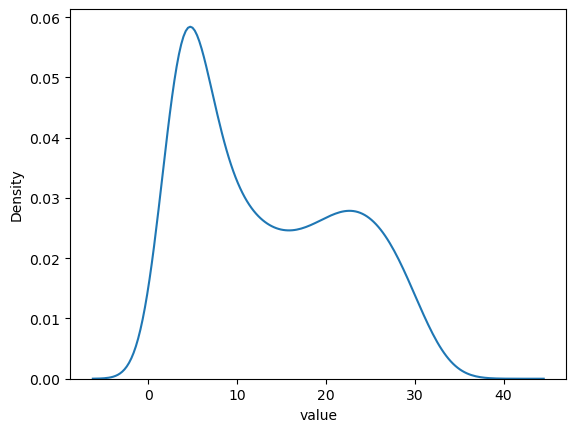

In [3]:
# Binarization based on firing rate histogram of ALL networks
melted_binned_dt = pd.DataFrame()
freq_thresh = 0.1
dict_thresh_nuc = dict()
bin_num = 100

for i in np.arange(1,nseeds+1):
    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    binned_firing_rates = pd.read_csv(data_dir+"binned_firing_rates.csv")
    binned_firing_rates = binned_firing_rates.loc[:,~binned_firing_rates.columns.str.contains("Unnamed")]
    
    non_fr_cols = list(set(binned_firing_rates.columns)-set(input_channels))
    temp_melted_binned = pd.DataFrame()
    temp_melted_binned = binned_firing_rates.melt(id_vars=non_fr_cols)
    temp_melted_binned["channel"] = [x.split('_')[1]   for x in temp_melted_binned["variable"]]
    temp_melted_binned["nuclei"] = [x.split('_')[0]   for x in temp_melted_binned["variable"]]
    temp_melted_binned_dt = temp_melted_binned.loc[temp_melted_binned["phase"]==0]

    melted_binned_dt = pd.concat([melted_binned_dt,temp_melted_binned_dt])

for k, nu in enumerate(nuclei):
    temp_df = melted_binned_dt.loc[melted_binned_dt["nuclei"]==nu]
    temp_fr = np.array(temp_df["value"])
    counts, bin_edges = np.histogram(temp_fr,bins=bin_num)  
    x, y = bin_edges, counts
    x=(x[1:]+x[:-1])/2 
    plt.clf()
    
    kde_x, kde_y = sns.kdeplot(data=temp_df,x="value",bw_adjust=3).lines[0].get_data()
    local_max_ind = argrelextrema(kde_y, np.greater)
    if len(local_max_ind[0])>1:
        if (kde_x[local_max_ind[0][1]]-kde_x[local_max_ind[0][0]])/(kde_x.max()-kde_x.min())<0.65:
            dict_thresh_nuc[nu] = (kde_x[local_max_ind[0][0]]+kde_x[local_max_ind[0][1]])/2
        elif (nu=="GPi") | (nu=="GPeP"):
            for i in np.arange(bin_num):
                cum_count = np.cumsum(counts)
                cum_freq = cum_count/len(temp_fr)
                temp_val = list(filter(lambda i: i > freq_thresh, cum_freq))[0]
                temp_ind = list(cum_freq).index(temp_val)
            dict_thresh_nuc[nu] = bin_edges[temp_ind]
        else:
            for i in np.arange(bin_num):
                cum_count = np.cumsum(counts)
                cum_freq = cum_count/len(temp_fr)
                temp_val = list(filter(lambda i: i > 1-freq_thresh, cum_freq))[0]
                temp_ind = list(cum_freq).index(temp_val)
            dict_thresh_nuc[nu] = bin_edges[temp_ind]
    elif (nu=="GPi") | (nu=="GPeP"):
        for i in np.arange(bin_num):
            cum_count = np.cumsum(counts)
            cum_freq = cum_count/len(temp_fr)
            temp_val = list(filter(lambda i: i > freq_thresh, cum_freq))[0]
            temp_ind = list(cum_freq).index(temp_val)
        dict_thresh_nuc[nu] = bin_edges[temp_ind]
    else:
        for i in np.arange(bin_num):
            cum_count = np.cumsum(counts)
            cum_freq = cum_count/len(temp_fr)
            temp_val = list(filter(lambda i: i > 1-freq_thresh, cum_freq))[0]
            temp_ind = list(cum_freq).index(temp_val)
        dict_thresh_nuc[nu] = bin_edges[temp_ind]
  
dict_thresh = {'CxI_common': dict_thresh_nuc["CxI"], 
               'Cx_left': dict_thresh_nuc["Cx"], 'Cx_right': dict_thresh_nuc["Cx"],
               'dSPN_left': dict_thresh_nuc["dSPN"], 'dSPN_right': dict_thresh_nuc["dSPN"], 
               'iSPN_left': dict_thresh_nuc["iSPN"], 'iSPN_right': dict_thresh_nuc["iSPN"], 
               'FSI_common': dict_thresh_nuc["FSI"], 
               'GPeP_left': dict_thresh_nuc["GPeP"], 'GPeP_right': dict_thresh_nuc["GPeP"], 
               'GPeA_left': dict_thresh_nuc["GPeA"], 'GPeA_right': dict_thresh_nuc["GPeA"], 
               'GPi_left': dict_thresh_nuc["GPi"], 'GPi_right': dict_thresh_nuc["GPi"], 
               'STN_left': dict_thresh_nuc["STN"], 'STN_right': dict_thresh_nuc["STN"],
               'Th_left': dict_thresh_nuc["Th"], 'Th_right':dict_thresh_nuc["Th"]}
print(dict_thresh)

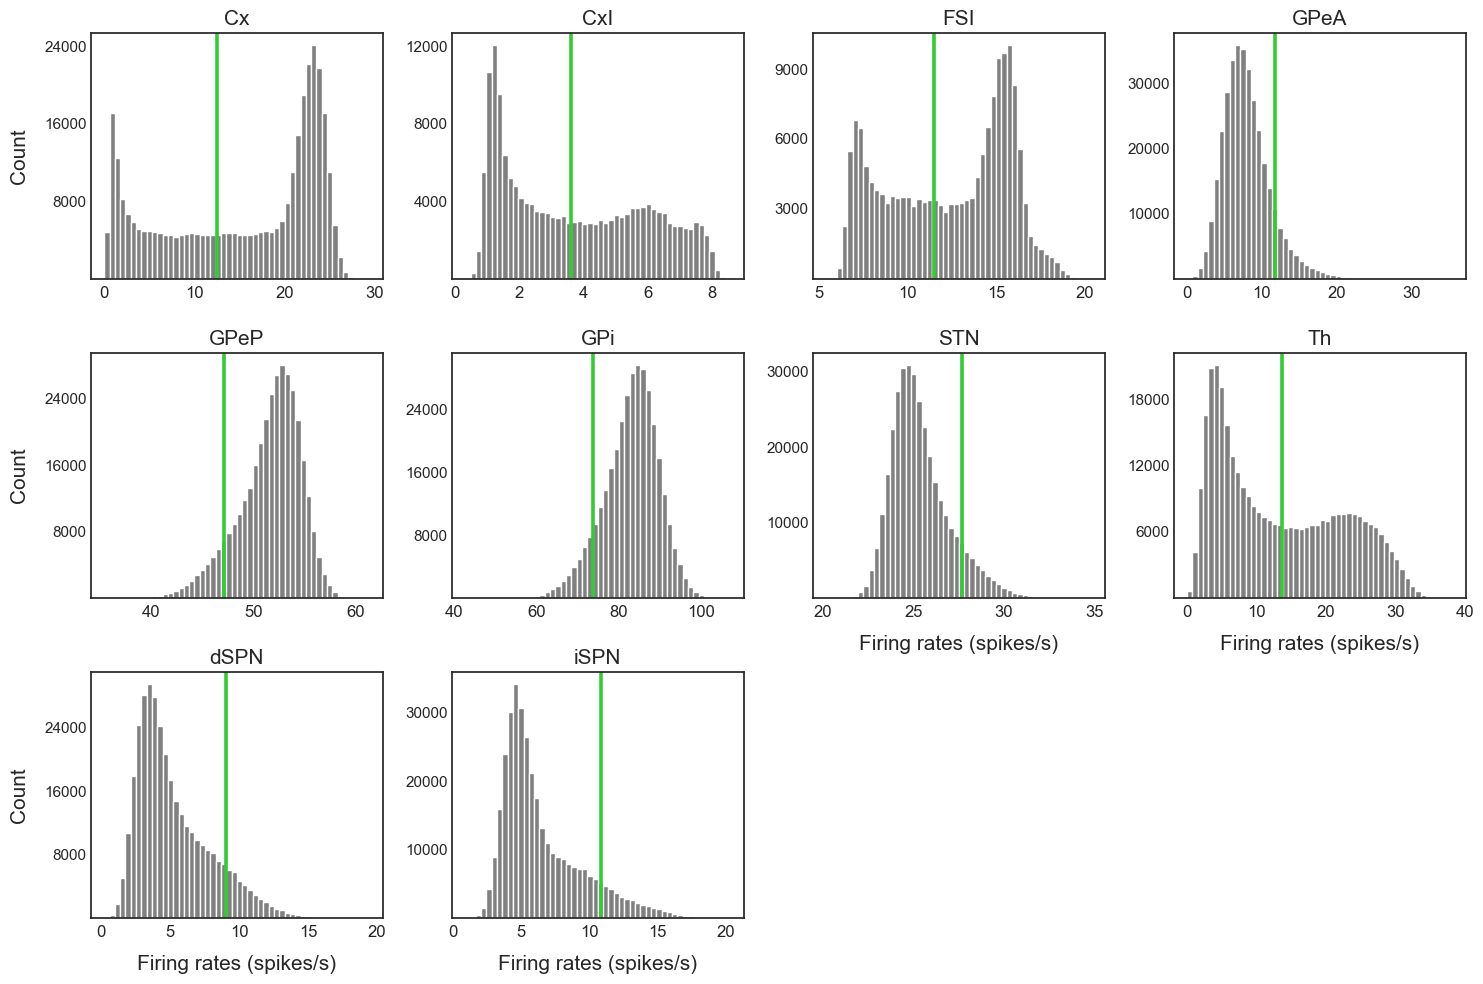

In [ ]:
# Histogram of firing rates and binarization threshold (Fig 10)
sns.set_theme(style='white')
g1 = melted_binned_dt.hist(column='value',by='nuclei',bins=50,color='gray',xlabelsize=8,ylabelsize=8,figsize=(15,10),layout=(3,4),zorder=2)
for k, x in enumerate(g1.ravel()[:10]):
    nuc = x.get_title()
    x.axvline(dict_thresh_nuc[nuc],0,linewidth=2.6,color='limegreen')
    x.title.set_size(15)
    x.set_xlabel(None,fontsize=15)
    x.set_ylabel(None,fontsize=15)
    if (k==0) | (k==4) | (k==8):
        x.set_ylabel("Count",fontsize=15,labelpad=11)
    if (k>=6):
        x.set_xlabel("Firing rates (spikes/s)",fontsize=15,labelpad=11)
    x.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=4))
    x.tick_params(axis="y", labelsize=11, pad=-3)
    x.tick_params(axis="x", labelsize=12, pad=-1, rotation=0)
plt.tight_layout()

In [21]:
# Obtain binarized firing rates for each network
for i in np.arange(1,nseeds+1):
    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    binned_firing_rates = pd.read_csv(data_dir+"binned_firing_rates.csv")
    binned_firing_rates = binned_firing_rates.loc[:,~binned_firing_rates.columns.str.contains("Unnamed")]
    
    binarized_firing_rates = pd.DataFrame()
    binarized_firing_rates = binned_firing_rates.copy()
    non_fr_cols = list(set(binned_firing_rates.columns)-set(input_channels))
    
    for ip_ch in input_channels:
        temp_thresh = dict_thresh[ip_ch]
        binarized_firing_rates[ip_ch] = [ 0 if x < temp_thresh else 1 for x in binarized_firing_rates[ip_ch]]
    
    binarized_firing_rates.to_csv(data_dir+"binarized_firing_rates.csv")

/var/folders/4f/ff84h74s15dbg7j03l96xsk80000gp/T/ipykernel_1540/690564310.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['adjusted_value'] = dat.apply(
/var/folders/4f/ff84h74s15dbg7j03l96xsk80000gp/T/ipykernel_1540/690564310.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['adjusted_value'] = dat.apply(
/var/folders/4f/ff84h74s15dbg7j03l96xsk80000gp/T/ipykernel_1540/690564310.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

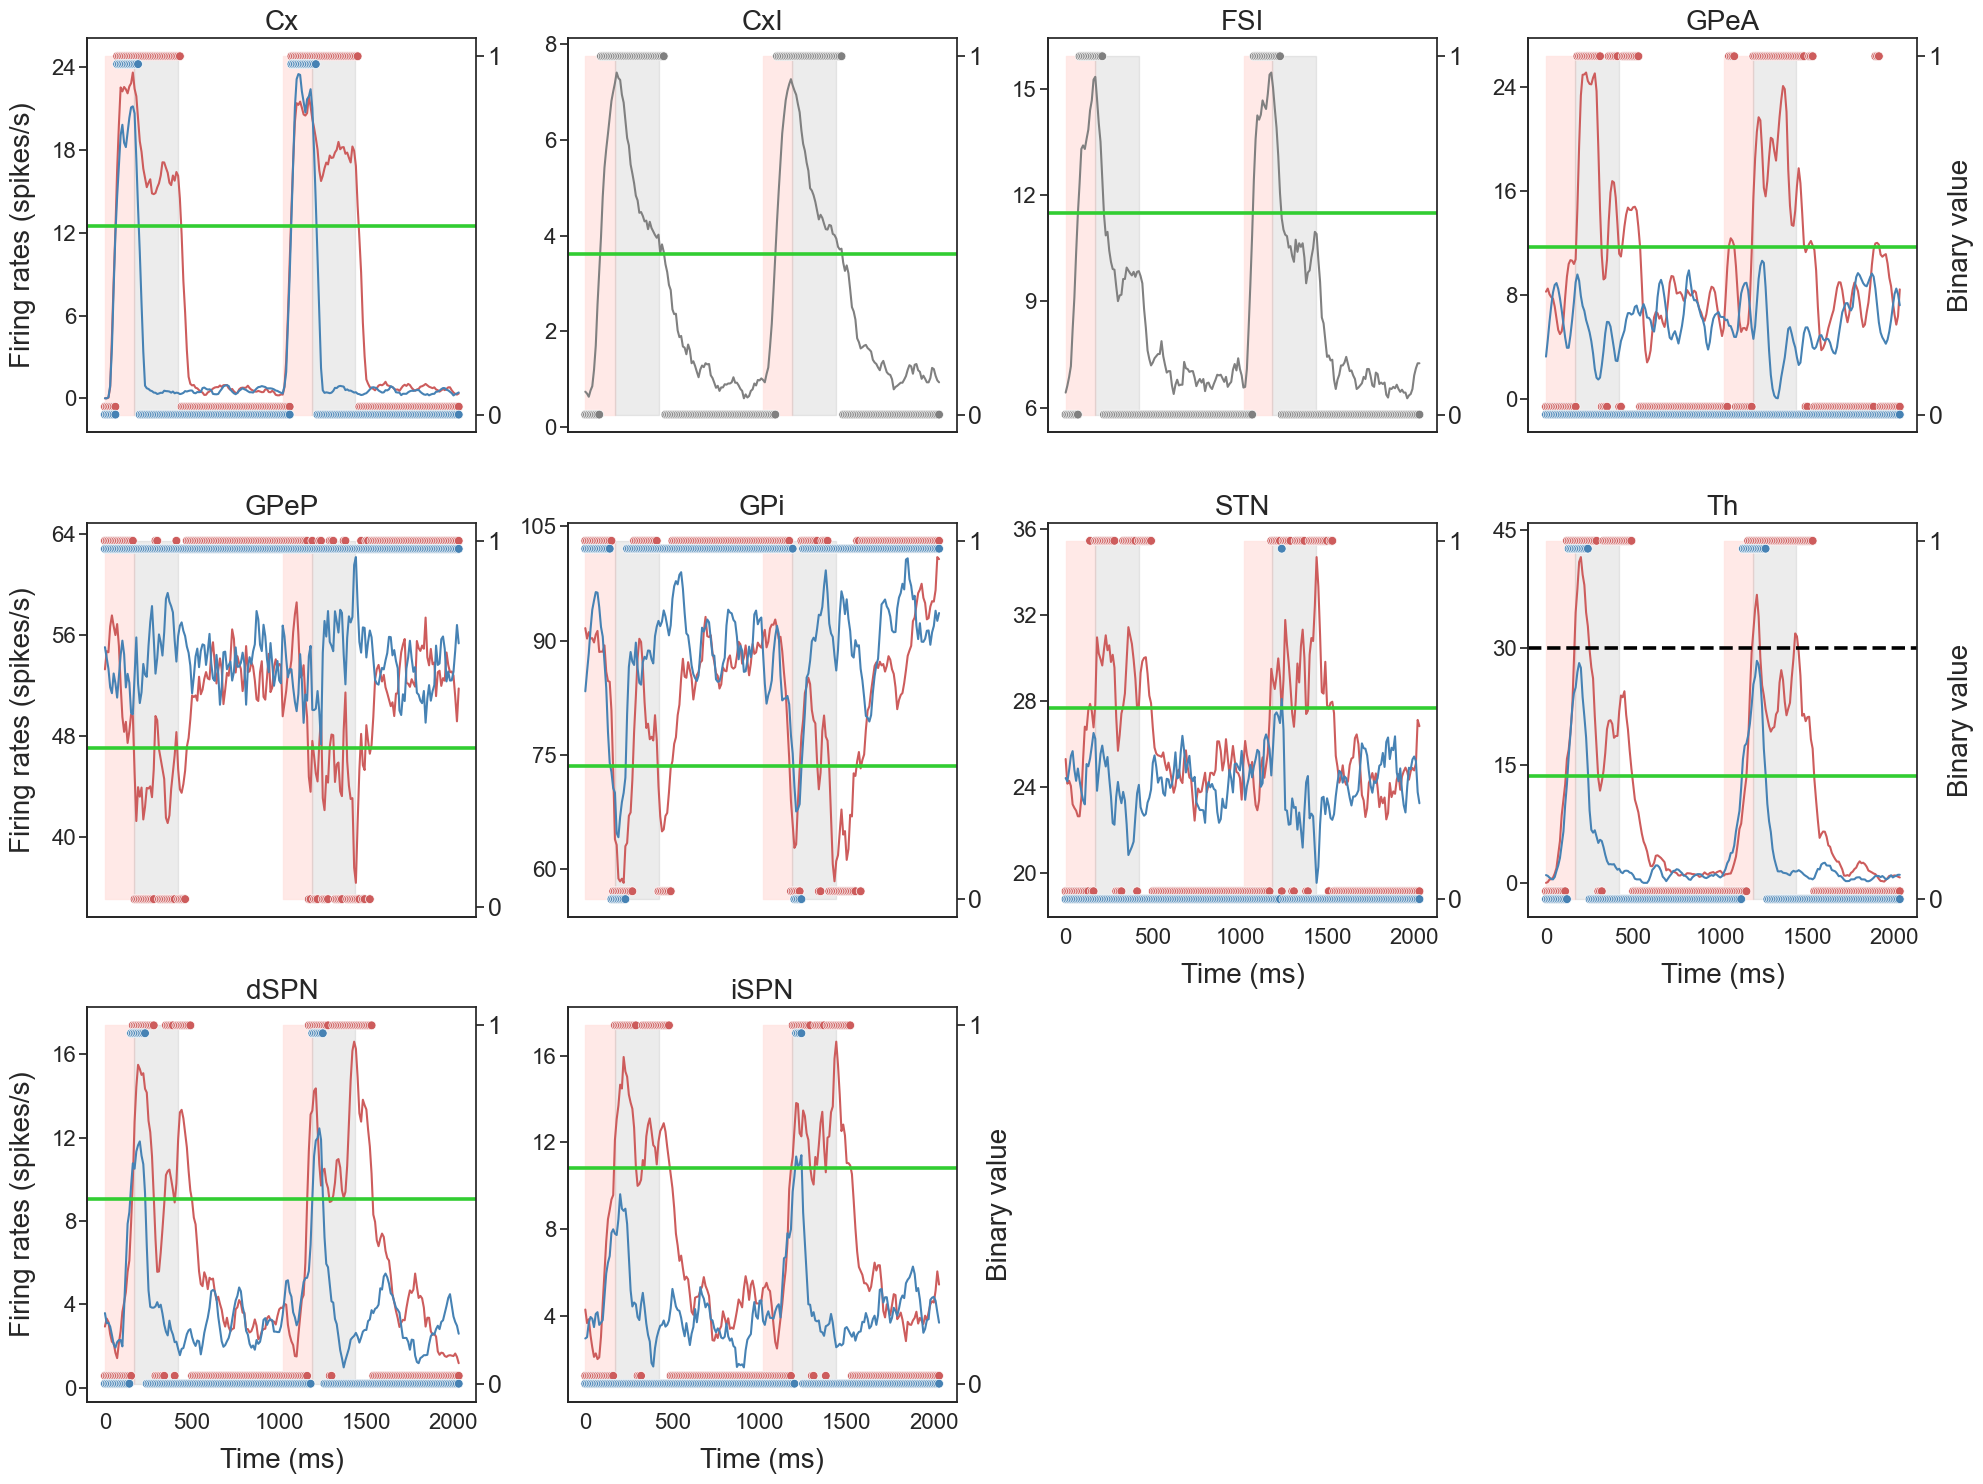

In [ ]:
# Example figure of nuclei firing rates (Fig 2)
sns.set_theme(font_scale = 2.0)
sns.set_theme(style='white')
col_order=["Cx", "CxI", "FSI", "GPeA", "GPeP", "GPi", "STN", "Th", "dSPN", "iSPN"]
trial_num_plot=2
for i in [2]: 
    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    binned_firing_rates = pd.read_csv(data_dir+"binned_firing_rates.csv")
    binned_firing_rates = binned_firing_rates.loc[:,~binned_firing_rates.columns.str.contains("Unnamed")]
    binarized_firing_rates = pd.read_csv(data_dir+"binarized_firing_rates.csv")
    binarized_firing_rates = binarized_firing_rates.loc[:,~binarized_firing_rates.columns.str.contains("Unnamed")]
    
    nw_data = pickle.load(open(data_dir+"network_"+str(seed_num)+".pickle","rb"))
    nw = nw_data[0]
    datatabs = nw['datatables']
    start_times = np.array(datatabs["stimulusstarttime"].values).astype(float)
    decision_times = np.array(datatabs["decisiontime"].values).astype(float)
    reward_times = np.array(datatabs["rewardtime"].values).astype(float)

    non_fr_cols = list(set(binned_firing_rates.columns)-set(input_channels))
    melted_binned = pd.DataFrame()
    melted_binned = binned_firing_rates.melt(id_vars=non_fr_cols)
    melted_binned["channel"] = [x.split('_')[1]   for x in melted_binned["variable"]]
    melted_binned["nuclei"] = [x.split('_')[0]   for x in melted_binned["variable"]]

    melted_binarized = pd.DataFrame()    
    melted_binarized = binarized_firing_rates.melt(id_vars=non_fr_cols)
    melted_binarized["channel"] = [x.split('_')[1]  for x in melted_binarized["variable"]]
    melted_binarized["nuclei"] = [x.split('_')[0]  for x in melted_binarized["variable"]]
    
    for grp in melted_binned.groupby(["conflict","seed"]):
        if str(grp[0][1])==str(seed_num)+"_0":
            data = grp[1].loc[grp[1]["trial_num"]<trial_num_plot]
            palette = {'common': "gray", 'left':"indianred", 'right':"steelblue"}
            g1 = sns.relplot(x="Time(ms)",y="value",col="nuclei",col_wrap=4,data=data,kind='line',hue='channel',col_order=col_order,palette=palette,legend=False,facet_kws={'sharey':False,'sharex':True})
            for k, ax in enumerate(g1.figure.axes):
                nuc = ax.get_title().split(' = ')[1] 
                ax.set_title(nuc)
                ax.title.set_size(20)
                ax.set_xlabel(None,fontsize=20)
                ax.set_ylabel(None,fontsize=20)
                ymin, ymax = ax.get_ylim()
                for j in np.arange(trial_num_plot):
                    ax.fill_betweenx(y=[ymin,ymax],x1=start_times[j],x2=decision_times[j],color='mistyrose',alpha=0.8)
                    ax.fill_betweenx(y=[ymin,ymax],x1=decision_times[j],x2=reward_times[j],color='grey',alpha=0.15)
                if (k==0) | (k==4) | (k==8):
                    ax.set_ylabel("Firing rates (spikes/s)",fontsize=20,labelpad=11)
                if (k>=6):
                    ax.set_xlabel("Time (ms)",fontsize=20,labelpad=11)
                ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=5))
                ax.tick_params(axis="x",labelsize=16,pad=2)
                ax.tick_params(axis="y",labelsize=16,pad=2)
                dat = melted_binarized.loc[(melted_binarized["conflict"]==grp[0][0])&(melted_binarized["seed"]==grp[0][1])&(melted_binarized["nuclei"]==nuc)&(melted_binarized["trial_num"]<trial_num_plot)]
                dat['adjusted_value'] = dat.apply(
                        lambda row: 0.022 if row['channel']=='left' and row['value']==0 else
                                    0.978 if row['channel']=='right' and row['value']==1 else
                                    row['value'], axis=1
                )
                ax1 = ax.twinx()
                sns.scatterplot(x="Time(ms)",y="adjusted_value",hue="channel",ax=ax1,data=dat,palette=palette,s=40,legend=False)
                ax1.set_ylabel(None,fontsize=20)
                if (k==3) | (k==7) | (k==9):
                    ax1.set_ylabel("Binary value",fontsize=20)
                ax1.set_yticks((0,1)) 
                ax1.tick_params(axis="y",labelsize=18,pad=2)
                ax.axhline(dict_thresh_nuc[nuc], linewidth=2.6, color='limegreen')
                if k==7:
                    ax.axhline(30, linewidth=2.6, linestyle='--', color='black')
            plt.tight_layout()

In [9]:
# For each network, run assign_states.py to insert state index to binned data (long time!!)
# and obtain data_conf

In [ ]:
# Find the activation level of arkys and STNs (Fig 3C)
state_num = 507
arky_STN = pd.DataFrame()

for i in np.arange(1,nseeds+1):

    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    binarized_firing_rates = pd.read_csv(data_dir+"binarized_firing_rates.csv")
    binarized_firing_rates = binarized_firing_rates.loc[:,~binarized_firing_rates.columns.str.contains("Unnamed")]
    binarized_firing_rates_new = binarized_firing_rates.loc[binarized_firing_rates["phase"]==0]
    data_conf = pd.read_csv(data_dir+"data_conf.csv")
    data_conf = data_conf.loc[:,~data_conf.columns.str.contains("Unnamed")]

    data_conf_all = data_conf.loc[data_conf["phase"]==0].copy()  
    data_conf_all["GPeA_left"]=binarized_firing_rates_new["GPeA_left"]
    data_conf_all["GPeA_right"]=binarized_firing_rates_new["GPeA_right"]
    data_conf_all["STN_left"]=binarized_firing_rates_new["STN_left"]
    data_conf_all["STN_right"]=binarized_firing_rates_new["STN_right"]

    temp_df=data_conf_all.loc[data_conf_all["state_num"]==state_num]
    arky_STN = pd.concat([arky_STN,temp_df])

arky_left_on=arky_STN.loc[arky_STN["GPeA_left"]==1]
arky_right_on=arky_STN.loc[arky_STN["GPeA_right"]==1]
arky_left_on_per=len(arky_left_on)/len(arky_STN)
arky_right_on_per=len(arky_right_on)/len(arky_STN)
print("Arkys:", arky_left_on_per, arky_right_on_per)

STN_left_on=arky_STN.loc[arky_STN["STN_left"]==1]
STN_right_on=arky_STN.loc[arky_STN["STN_right"]==1]
STN_left_on_per=len(STN_left_on)/len(arky_STN)
STN_right_on_per=len(STN_right_on)/len(arky_STN)
print("STNs:", STN_left_on_per, STN_right_on_per)

Arkys: 0.6779661016949152 0.5508474576271186
STNs: 0.3267419962335217 0.9444444444444444


/var/folders/4f/ff84h74s15dbg7j03l96xsk80000gp/T/ipykernel_1540/2960077107.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Bin Edges")


([<matplotlib.axis.YTick at 0x2bc1c0eb0>,
 [Text(0, 0, '0'),
  Text(0, 20, '20'),
  Text(0, 40, '40'),
  Text(0, 60, '60'),
  Text(0, 80, '80')])

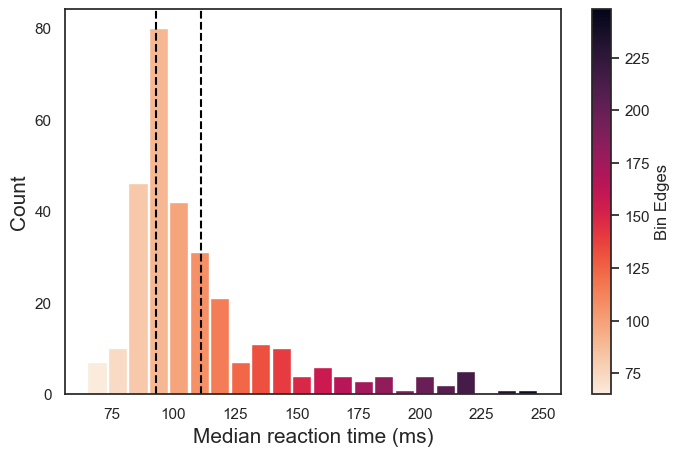

In [ ]:
# Find the median reaction time of each network (Fig 3B)
rt_median_all = []
for i in np.arange(1,nseeds+1):
    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    nw_data = pickle.load(open(data_dir+"network_"+str(seed_num)+".pickle","rb"))
    rt_all = []
    for j in np.arange(len(nw_data)):
        nw = nw_data[j]
        datatabs = nw['datatables']
        reaction_time = np.array(datatabs["decisionduration"].values).astype(int)
        rt_all = np.concatenate((rt_all, reaction_time))
    rt_median = statistics.median(rt_all) 
    rt_median_all.append(rt_median)

# Index of slow, fast, intermedium networks
indexed_rt_median = list(enumerate(rt_median_all))
sorted_rt_median = sorted(indexed_rt_median, key=lambda x: x[1], reverse=True)
slow_indices = [ind for ind, val in sorted_rt_median[:100]]
sorted_rt_median = sorted(indexed_rt_median, key=lambda x: x[1], reverse=False)
fast_indices = [ind for ind, val in sorted_rt_median[:100]]
medium_indices = [ind for ind in list(range(nseeds)) if ind not in slow_indices and ind not in fast_indices]

fig = plt.figure(figsize =(8,5))
n, bins, patches = plt.hist(rt_median_all,bins=22,width=7.8)
norm = plt.Normalize(vmin=min(bins), vmax=max(bins)) 
cmap = plt.get_cmap('rocket_r')  
plt.axvline(x=max([rt_median_all[i] for i in fast_indices]),color='black',linestyle='--')
plt.axvline(x=min([rt_median_all[i] for i in slow_indices]),color='black',linestyle='--')
plt.xlabel("Median reaction time (ms)", fontsize=15) 
plt.ylabel("Count", fontsize=15)
for i in range(len(patches)):
    color = cmap(norm(bins[i]))  
    patches[i].set_facecolor(color)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Bin Edges")
plt.yticks([0, 20, 40, 60, 80])

In [23]:
# Find all state sequences
states_seq = []
states_freq_left = dict()
states_freq_right = dict()

for i in np.arange(1,nseeds+1):

    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    data_conf = pd.read_csv(data_dir+"data_conf.csv")
    data_conf = data_conf.loc[:,~data_conf.columns.str.contains("Unnamed")]

    data_conf_new = data_conf.loc[data_conf["phase"]==0] 

    left_fr = data_conf_new.loc[(data_conf_new["chosen_action"]=="left")]
    right_fr = data_conf_new.loc[(data_conf_new["chosen_action"]=="right")]

    seeds_ind = np.unique(left_fr["seed"])
    left_ids = []
    right_ids = []
    for seed_ind in seeds_ind:
        temp_left_fr = left_fr.loc[(left_fr["seed"]==seed_ind)]
        temp_right_fr = right_fr.loc[(right_fr["seed"]==seed_ind)]
        temp_left_trials = np.unique(temp_left_fr["trial_num"])
        temp_right_trials = np.unique(temp_right_fr["trial_num"])
        for trial_id in temp_left_trials:
            left_ids.append([trial_id,str(seed_ind)])
        for trial_id in temp_right_trials:
            right_ids.append([trial_id,str(seed_ind)])
    
    for k, left_id in enumerate(left_ids):
        lind = left_id[0]
        lid = str(left_id[1])
        st_df = left_fr.loc[(left_fr["trial_num"]==lind)&(left_fr["seed"]==lid)] 
        for i in np.arange(len(st_df)):
            st = st_df.iloc[i]["state_num"]
            if i == 0:
                st_prev = st
                states_seq.append(st)
                if st in states_freq_left.keys():
                    states_freq_left[st]+=1
                else:
                    states_freq_left[st]=1
            if (i != 0) & (st != st_prev):
                st_prev = st
                states_seq.append(st)
                if st in states_freq_left.keys():
                    states_freq_left[st]+=1
                else:
                    states_freq_left[st]=1
                
    for k, right_id in enumerate(right_ids):
        lind = right_id[0]
        lid = str(right_id[1])
        st_df = right_fr.loc[(right_fr["trial_num"]==lind)&(right_fr["seed"]==lid)] 
        for i in np.arange(len(st_df)):
            st = st_df.iloc[i]["state_num"]
            if i == 0:
                st_prev = st
                states_seq.append(st)
                if st in states_freq_right.keys():
                    states_freq_right[st]+=1
                else:
                    states_freq_right[st]=1
            if (i != 0) & (st != st_prev):
                st_prev = st
                states_seq.append(st)  
                if st in states_freq_right.keys():
                    states_freq_right[st]+=1
                else:
                    states_freq_right[st]=1

sum_left = sum(states_freq_left.values())
sum_right = sum(states_freq_right.values())

In [24]:
# Calculate transition probabilities
def transition_matrix(seq,n):
    M = [[0]*n for _ in range(n)]
    for (i,j) in zip(seq,seq[1:]):
        M[i][j] += 1
    for row in M:  #convert to probabilities
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M
markov_mat = transition_matrix(states_seq,1024)

In [27]:
# Transition probability from current state to the subsequent states (Fig 3A)
# If the next state is "60", the decision is reached
markov = markov_mat
test_num = 60
ind_transition = np.where((np.array(markov[test_num]))>0)[0]
next_state_prob = [markov[test_num][j] for j in ind_transition]
next = [(ind_transition[j],next_state_prob[j]) for j in np.arange(len(ind_transition))]
next = sorted(next, key=lambda x: x[1], reverse=True)
next

[(60, 0.181203007518797),
 (303, 0.13834586466165413),
 (315, 0.09172932330827067),
 (831, 0.0887218045112782),
 (299, 0.06466165413533835),
 (379, 0.05488721804511278),
 (363, 0.0481203007518797),
 (815, 0.039097744360902256),
 (783, 0.02330827067669173),
 (63, 0.021052631578947368),
 (891, 0.015789473684210527),
 (827, 0.014285714285714285),
 (811, 0.012781954887218045),
 (843, 0.011278195488721804),
 (311, 0.009774436090225564),
 (367, 0.009774436090225564),
 (823, 0.009022556390977444),
 (779, 0.008270676691729323),
 (875, 0.008270676691729323),
 (295, 0.007518796992481203),
 (575, 0.007518796992481203),
 (799, 0.007518796992481203),
 (271, 0.006766917293233083),
 (383, 0.006766917293233083),
 (807, 0.006766917293233083),
 (951, 0.006766917293233083),
 (439, 0.005263157894736842),
 (895, 0.005263157894736842),
 (1019, 0.005263157894736842),
 (507, 0.004511278195488722),
 (935, 0.004511278195488722),
 (423, 0.0037593984962406013),
 (959, 0.0037593984962406013),
 (1015, 0.00375939849

In [29]:
# Tell L:R for a state (Fig 3C)
test_num = 60
if (states_freq_left[test_num]>0) & (states_freq_right[test_num]>0):
    ratio_left=round(10*states_freq_left[test_num]/(states_freq_left[test_num]+states_freq_right[test_num]))
    ratio_right=round(10*states_freq_right[test_num]/(states_freq_left[test_num]+states_freq_right[test_num]))
    print("L:R ratio is: "+str(ratio_left)+":"+str(ratio_right))

L:R ratio is: 5:5


In [17]:
# Find the mean RT of a state and KL divergence between left and right RT distributions (Fig 3C)
test_num = 60

reaction_times_left=[]
for i in np.arange(1,nseeds+1):
    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    data_conf = pd.read_csv(data_dir+"data_conf.csv")
    data_conf = data_conf.loc[:,~data_conf.columns.str.contains("Unnamed")]
    data_conf_new = data_conf.loc[data_conf["phase"]==0] 

    nw_data = pickle.load(open(data_dir+"network_"+str(seed_num)+".pickle","rb"))
        
    left_fr = data_conf_new.loc[(data_conf_new["chosen_action"]=="left")]
    temp = left_fr.loc[left_fr["state_num"]==test_num]
        
    for grp in temp.groupby(["trial_num","seed"]):
        nw = nw_data[int(grp[0][1].split('_')[1])]
        datatabs = nw['datatables']
        reaction_time = datatabs["decisionduration"][grp[0][0]]
        reaction_times_left.append(reaction_time)

reaction_times_right=[]
for i in np.arange(1,nseeds+1):
    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    data_conf = pd.read_csv(data_dir+"data_conf.csv")
    data_conf = data_conf.loc[:,~data_conf.columns.str.contains("Unnamed")]
    data_conf_new = data_conf.loc[data_conf["phase"]==0] 

    nw_data = pickle.load(open(data_dir+"network_"+str(seed_num)+".pickle","rb"))
        
    right_fr = data_conf_new.loc[(data_conf_new["chosen_action"]=="right")]
    temp = right_fr.loc[right_fr["state_num"]==test_num]
        
    for grp in temp.groupby(["trial_num","seed"]):
        nw = nw_data[int(grp[0][1].split('_')[1])]
        datatabs = nw['datatables']
        reaction_time = datatabs["decisionduration"][grp[0][0]]
        reaction_times_right.append(reaction_time)

print("Left average: ", np.mean(reaction_times_left))
print("Right average: ", np.mean(reaction_times_right))
print("All average: ", np.mean(reaction_times_left+reaction_times_right))

# KL-divergence 
bin_num = 100
bin_range = (min(min(reaction_times_left),min(reaction_times_right)), max(max(reaction_times_left),max(reaction_times_right)))
epsilon = 0.0001
counts_left, bin_edges_left = np.histogram(reaction_times_left, bins=bin_num, range=bin_range)
counts_right, bin_edges_right = np.histogram(reaction_times_right, bins=bin_num, range=bin_range)
sum_rt_left, sum_rt_right = sum(counts_left), sum(counts_right)
rt_left_freq, rt_right_freq = counts_left/sum_rt_left, counts_right/sum_rt_right
rt_left_freq[rt_left_freq==0]=epsilon
rt_right_freq[rt_right_freq==0]=epsilon
KLdivergence = entropy(rt_right_freq, rt_left_freq)
print("KLdivergence =", KLdivergence)

Left average:  115.46195351411178
Right average:  115.55707056508294
All average:  115.50913401199274
KLdivergence = 0.012545857135061962


In [ ]:
# Find the conditional probability of visiting a zone (Fig 4A)
zone_num = 1

zones = {1: [60, 61, 62, 63], 
        2: [55, 59, 183, 123, 191, 127], 
        3: [575, 543, 535, 663], 
        4: [319, 303, 299, 363], 
        5: [247, 251, 243, 759, 507],
        6: [783]}

zone_freq = dict()

for i in np.arange(1,nseeds+1):
    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    data_conf = pd.read_csv(data_dir+"data_conf.csv")
    data_conf = data_conf.loc[:,~data_conf.columns.str.contains("Unnamed")]
    data_conf_new = data_conf.loc[data_conf["phase"]==0] 

    for j in np.arange(50):
        temp = data_conf_new.loc[data_conf_new["trial_num"]==j] 
        temp_st = list(temp['state_num'])
        temp_st_unique = []
        [temp_st_unique.append(st) for st in temp_st if st not in temp_st_unique]

        for k, st_curr in enumerate(temp_st_unique):
            if k < len(temp_st_unique)-1:
                st_next = temp_st_unique[k+1]
            else:
                st_next = st_curr
            zone_next = [zone for zone, value in zones.items() if st_next in value]
            if (st_curr in zones[zone_num]) & (len(zone_next)>0):
                if zone_next[0] in zone_freq.keys():
                    zone_freq[zone_next[0]]+=1
                else:
                    zone_freq[zone_next[0]]=1 

sum_zone_freq = sum(zone_freq.values())
zone_freq = {key: value/sum_zone_freq for key, value in zone_freq.items()} 
print(zone_freq)       

{1: 0.6953711271268296, 4: 0.08514748495430567, 2: 0.12214874804963222, 3: 0.08340144141466677, 5: 0.006724125120737053, 6: 0.007207073333828665}


In [32]:
# Find the overall cell activation in each zone (Fig 4B)
zone_num = 1

zones = {1: [60, 61, 62, 63], 
        2: [55, 59, 183, 123, 191, 127], 
        3: [575, 543, 535, 663], 
        4: [319, 303, 299, 363], 
        5: [247, 251, 243, 759, 507],
        6: [783]}

fr_all = pd.DataFrame()
for i in np.arange(1,nseeds+1):
    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    data_conf = pd.read_csv(data_dir+"data_conf.csv")
    data_conf = data_conf.loc[:,~data_conf.columns.str.contains("Unnamed")]
    data_conf_new = data_conf.loc[data_conf["phase"]==0] 

    binned_firing_rates = pd.read_csv(data_dir+"binned_firing_rates.csv")
    binned_firing_rates = binned_firing_rates.loc[:,~binned_firing_rates.columns.str.contains("Unnamed")]
    
    for st in zones[zone_num]:
        inds = data_conf_new.index[data_conf_new["state_num"]==st].tolist()
        if len(inds) > 0:
            temp = binned_firing_rates.iloc[inds]
            fr_all = pd.concat([fr_all,temp])

# Probability of activation over time
zone_prob = dict()
for nuc in interested_nuc:
    count_above = (fr_all[nuc] > dict_thresh[nuc]).sum()
    zone_prob[nuc] = count_above/len(fr_all)
zone_prob

{'dSPN_left': 0.0,
 'dSPN_right': 0.0,
 'iSPN_left': 0.0,
 'iSPN_right': 0.0,
 'GPi_left': 1.0,
 'GPi_right': 1.0,
 'GPeP_left': 1.0,
 'GPeP_right': 1.0,
 'GPeA_left': 0.047128646660536656,
 'GPeA_right': 0.048733595252027084,
 'STN_left': 0.008726907966229207,
 'STN_right': 0.008660035108250438,
 'Th_left': 0.23270918665886484,
 'Th_right': 0.23364540667056757}

In [ ]:
# Find the matrix of average firing rates, F, of all networks
F_col_ind = ['FSI','CxI','GPi_sum','STN_sum','GPeP_sum','GPeA_sum','dSPN_sum','iSPN_sum','Cx_sum','Th_sum',
            'GPi_diff','STN_diff','GPeP_diff','GPeA_diff','dSPN_diff','iSPN_diff','Cx_diff','Th_diff']
F_matrix = np.empty((0,18),float)
for i in np.arange(1,nseeds+1):
    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    firing_rate = pd.compat.pickle_compat.load(open(data_dir+"firing_rates.pickle","rb"))
    fr = firing_rate[0]
    F_temp = np.array([[np.array(fr.loc[fr["variable"]=="FSI_common"]["firing_rate"]).mean(),
                    np.array(fr.loc[fr["variable"]=="CxI_common"]["firing_rate"]).mean(),
                    (np.array(fr.loc[fr["variable"]=="GPi_left"]["firing_rate"])+np.array(fr.loc[fr["variable"]=="GPi_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="STN_left"]["firing_rate"])+np.array(fr.loc[fr["variable"]=="STN_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="GPeP_left"]["firing_rate"])+np.array(fr.loc[fr["variable"]=="GPeP_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="GPeA_left"]["firing_rate"])+np.array(fr.loc[fr["variable"]=="GPeA_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="dSPN_left"]["firing_rate"])+np.array(fr.loc[fr["variable"]=="dSPN_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="iSPN_left"]["firing_rate"])+np.array(fr.loc[fr["variable"]=="iSPN_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="Cx_left"]["firing_rate"])+np.array(fr.loc[fr["variable"]=="Cx_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="Th_left"]["firing_rate"])+np.array(fr.loc[fr["variable"]=="Th_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="GPi_left"]["firing_rate"])-np.array(fr.loc[fr["variable"]=="GPi_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="STN_left"]["firing_rate"])-np.array(fr.loc[fr["variable"]=="STN_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="GPeP_left"]["firing_rate"])-np.array(fr.loc[fr["variable"]=="GPeP_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="GPeA_left"]["firing_rate"])-np.array(fr.loc[fr["variable"]=="GPeA_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="dSPN_left"]["firing_rate"])-np.array(fr.loc[fr["variable"]=="dSPN_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="iSPN_left"]["firing_rate"])-np.array(fr.loc[fr["variable"]=="iSPN_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="Cx_left"]["firing_rate"])-np.array(fr.loc[fr["variable"]=="Cx_right"]["firing_rate"])).mean(),
                    (np.array(fr.loc[fr["variable"]=="Th_left"]["firing_rate"])-np.array(fr.loc[fr["variable"]=="Th_right"]["firing_rate"])).mean()]])
    F_matrix = np.append(F_matrix,F_temp,axis=0)
np.save("./DDM/F_matrix.npy",F_matrix)

In [ ]:
# Find the matrix of DDM parameters, D, of all networks
hddm_results = pd.read_csv("../DDM/hddm_results.csv")
hddm_results = hddm_results.loc[:,~hddm_results.columns.str.contains("Unnamed")]
D_matrix = np.array(pd.DataFrame(hddm_results,columns=['mean_a','mean_v','mean_t','mean_z']))
np.save("./DDM/D_matrix.npy",D_matrix)

In [35]:
# CCA on (D_matrix, F_matrix) 
D_matrix_all = np.load("./DDM/D_matrix.npy")
F_matrix_all = np.load("./DDM/F_matrix.npy")

F_all_standard = (F_matrix_all-np.mean(F_matrix_all,axis=0))/np.std(F_matrix_all,axis=0)
D_all_standard = (D_matrix_all-np.mean(D_matrix_all,axis=0))/np.std(D_matrix_all,axis=0)

cca = CCA(n_components=3)
F_all_trans, D_all_trans = cca.fit_transform(F_all_standard,D_all_standard)
uload = cca.x_loadings_
vload = cca.y_loadings_
uweight = cca.x_weights_
vweight = cca.y_weights_

/var/folders/4f/ff84h74s15dbg7j03l96xsk80000gp/T/ipykernel_1540/3101116411.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('PiYG')


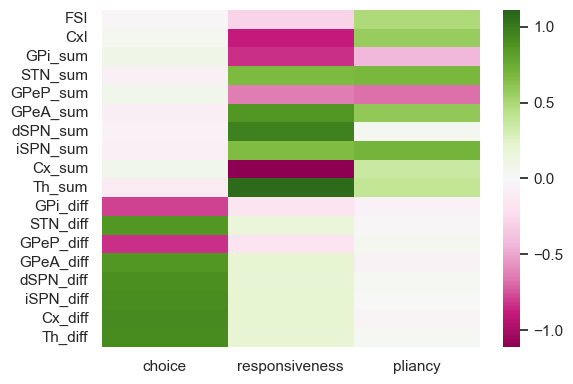

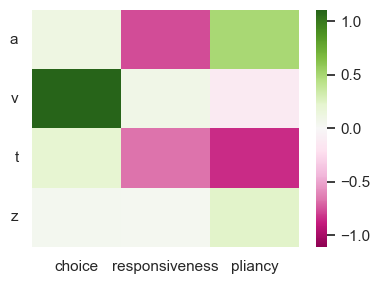

In [ ]:
# Plot loading vectors (Fig 6)
F_col_ind = ['FSI','CxI','GPi_sum','STN_sum','GPeP_sum','GPeA_sum','dSPN_sum','iSPN_sum','Cx_sum','Th_sum',
            'GPi_diff','STN_diff','GPeP_diff','GPeA_diff','dSPN_diff','iSPN_diff','Cx_diff','Th_diff']

uload[:,2] = -uload[:,2]
vload[:,2] = -vload[:,2]

cm = plt.cm.get_cmap('PiYG')
fig = plt.figure(figsize =(6,4))
vmax = abs(uload).max().max()
vmin = -vmax
ax = sns.heatmap(uload, yticklabels=True, cmap=cm, vmin=vmin, vmax=vmax)
ax.set_xticklabels(['choice','responsiveness','pliancy'])
ax.set_yticklabels([F_col_ind[k] for k in np.arange(len(F_col_ind))],rotation=0)
cbar = ax.collections[0].colorbar 
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
plt.tight_layout()
plt.show()

fig = plt.figure(figsize =(4,3))
vmax = abs(vload).max().max()
vmin = -vmax
ax = sns.heatmap(vload, yticklabels=True, cmap=cm, vmin=vmin, vmax=vmax)
ax.set_xticklabels(['choice','responsiveness','pliancy'])
ax.set_yticklabels(['a','v','t','z'],rotation=0)
plt.tight_layout()
plt.show()

In [37]:
# Find time series of control ensemble drives 
W_time_all = pd.DataFrame()
for i in np.arange(1,nseeds+1):
    seed_num = i
    data_dir = data_dir_all+"network_"+str(seed_num)+"/"
    binned_firing_rates = pd.read_csv(data_dir+"binned_firing_rates.csv")
    binned_firing_rates = binned_firing_rates.loc[:,~binned_firing_rates.columns.str.contains("Unnamed")]
    binned_firing_rates_new = binned_firing_rates.loc[binned_firing_rates["phase"]==0]

    for j in np.arange(50):
        temp = binned_firing_rates_new.loc[binned_firing_rates_new["trial_num"]==j]
        for nuc in input_channels:
            temp[nuc] = temp[nuc]-temp.iloc[0][nuc]
        temp_diff = temp.copy()
        for nuc in input_channels:
            temp_diff[nuc] = temp_diff[nuc].diff()
        temp_diff = temp_diff.fillna(0)

        for k in np.arange(1,len(temp_diff)):
            dat = temp_diff.iloc[k]
            Delta_F_t = np.array([[dat["FSI_common"], dat["CxI_common"], 
                            (dat["GPi_left"]+dat["GPi_right"]),
                            (dat["STN_left"]+dat["STN_right"]), 
                            (dat["GPeP_left"]+dat["GPeP_right"]),
                            (dat["GPeA_left"]+dat["GPeA_right"]),
                            (dat["dSPN_left"]+dat["dSPN_right"]), 
                            (dat["iSPN_left"]+dat["iSPN_right"]),
                            (dat["Cx_left"]+dat["Cx_right"]), 
                            (dat["Th_left"]+dat["Th_right"]),
                            (dat["GPi_left"]-dat["GPi_right"]), 
                            (dat["STN_left"]-dat["STN_right"]),
                            (dat["GPeP_left"]-dat["GPeP_right"]), 
                            (dat["GPeA_left"]-dat["GPeA_right"]),
                            (dat["dSPN_left"]-dat["dSPN_right"]),
                            (dat["iSPN_left"]-dat["iSPN_right"]), 
                            (dat["Cx_left"]-dat["Cx_right"]),
                            (dat["Th_left"]-dat["Th_right"])]])
            W_t = np.dot(Delta_F_t,uload)
            W_t_df = pd.DataFrame({"seed":[i], "trial":[j], "time (ms)":[10*k], "chosen_action": [temp["chosen_action"].iloc[0]],
                                    "choice":[W_t[0][0]], "responsiveness":[W_t[0][1]], "pliancy":[W_t[0][2]]})

            W_time_all = pd.concat([W_time_all,W_t_df])

# Time-locked to reaction times
W_time_all_rev = pd.DataFrame()
ind_all = W_time_all[['seed','trial']].drop_duplicates().values.tolist()
for i, (seed_num, trial_num) in enumerate(ind_all):
    temp = W_time_all.loc[(W_time_all["seed"]==seed_num)&(W_time_all["trial"]==trial_num)]
    temp["time_rev"] = temp["time (ms)"]-temp["time (ms)"].max()
    W_time_all_rev = pd.concat([W_time_all_rev,temp])
    
W_time_all_rev.to_csv(r"./DDM/W_time_all.csv")

/var/folders/4f/ff84h74s15dbg7j03l96xsk80000gp/T/ipykernel_1540/1718272857.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[nuc] = temp[nuc]-temp.iloc[0][nuc]
/var/folders/4f/ff84h74s15dbg7j03l96xsk80000gp/T/ipykernel_1540/1718272857.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[nuc] = temp[nuc]-temp.iloc[0][nuc]
/var/folders/4f/ff84h74s15dbg7j03l96xsk80000gp/T/ipykernel_1540/1718272857.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

(-6.5, 21.0)

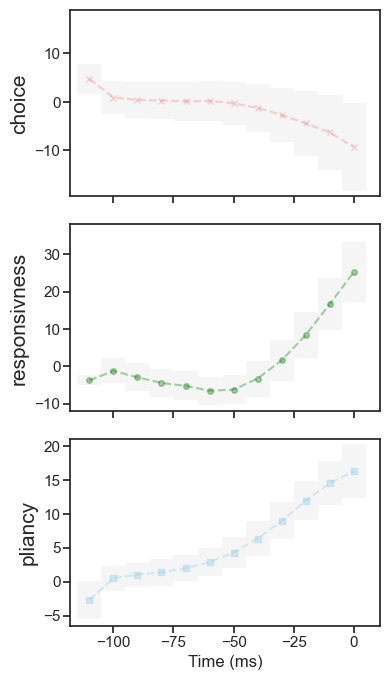

In [43]:
# Plot time series of control ensemble drives for each fast trials (Fig 7AC)
W_time_all = pd.read_csv("./DDM/W_time_all.csv")
W_time_all = W_time_all.loc[:,~W_time_all.columns.str.contains("Unnamed")]
W_time_all = W_time_all.loc[W_time_all["chosen_action"]=="right"]  #or "left"
W_time_all = W_time_all[(W_time_all['seed']-1).isin(fast_indices)]   

fig, axs = plt.subplots(3,1,figsize=(4,8))
time_min = -110   
W_mean_all = pd.DataFrame()
for t in np.arange(time_min,1,10):
    choice_mean_all = W_time_all.loc[W_time_all["time_rev"]==t]["choice"].mean()
    response_mean_all = W_time_all.loc[W_time_all["time_rev"]==t]["responsiveness"].mean()
    pliancy_mean_all = W_time_all.loc[W_time_all["time_rev"]==t]["pliancy"].mean()
    W_mean_temp = pd.DataFrame({"time_rev":[t], "choice_mean":[choice_mean_all], "response_mean":[response_mean_all], "pliancy_mean":[pliancy_mean_all]})
    W_mean_all = pd.concat([W_mean_all,W_mean_temp])

for t in np.arange(time_min,1,10):
    W_temp = W_time_all.loc[W_time_all['time_rev']==t]
    std_choice, std_response, std_pliancy = W_temp['choice'].std(), W_temp['responsiveness'].std(), W_temp['pliancy'].std()
    upper_choice, lower_choice = W_mean_all.loc[W_mean_all['time_rev']==t]['choice_mean']-std_choice, W_mean_all.loc[W_mean_all['time_rev']==t]['choice_mean']+std_choice
    upper_response, lower_response = W_mean_all.loc[W_mean_all['time_rev']==t]['response_mean']-std_response, W_mean_all.loc[W_mean_all['time_rev']==t]['response_mean']+std_response
    upper_pliancy, lower_pliancy = W_mean_all.loc[W_mean_all['time_rev']==t]['pliancy_mean']-std_pliancy, W_mean_all.loc[W_mean_all['time_rev']==t]['pliancy_mean']+std_pliancy

    axs[0].fill_between(np.linspace(t-5,t+5,20),y1=lower_choice,y2=upper_choice,color='grey',edgecolor='none',alpha=0.08)
    axs[1].fill_between(np.linspace(t-5,t+5,20),y1=lower_response,y2=upper_response,color='grey',edgecolor='none',alpha=0.08)
    axs[2].fill_between(np.linspace(t-5,t+5,20),y1=lower_pliancy,y2=upper_pliancy,color='grey',edgecolor='none',alpha=0.08)

axs[0].plot(W_mean_all["time_rev"],W_mean_all['choice_mean'], color='lightcoral',alpha=0.35,label='choice', marker='x',linestyle='--',markersize=4)
axs[1].plot(W_mean_all["time_rev"],W_mean_all['response_mean'],color='green',alpha=0.35,label='responsiveness',marker='o',linestyle='--',markersize=4)
axs[2].plot(W_mean_all["time_rev"],W_mean_all['pliancy_mean'],color='skyblue',alpha=0.35,label='pliancy',marker='s',linestyle='--',markersize=4)

plt.subplots_adjust(hspace=0.15)
axs[0].set_ylabel('choice', fontsize=15)
axs[0].tick_params(axis='x',direction='out',bottom=True,length=5,labelbottom=False)
axs[0].tick_params(axis='y',direction='out',left=True,length=5,pad=2)
axs[0].set_xlim(-118,)
axs[0].set_ylim(-19.5,19)
axs[1].set_ylabel('responsivness', fontsize=15)
axs[1].tick_params(axis='x',direction='out',bottom=True,length=5,labelbottom=False)
axs[1].tick_params(axis='y',direction='out',left=True,length=5,pad=2)
axs[1].set_xlim(-118,)
axs[1].set_ylim(-12,38)
axs[2].set_ylabel('pliancy', fontsize=15)
axs[2].set_xlabel('Time (ms)')
axs[2].tick_params(axis='x',direction='out',bottom=True,length=5,pad=2)
axs[2].tick_params(axis='y',direction='out',left=True,length=5,pad=2)
axs[2].set_xlim(-118,)
axs[2].set_ylim(-6.5,21)

(-6.5, 21.0)

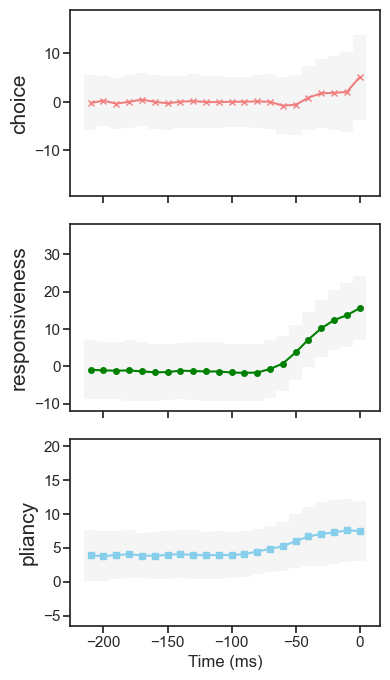

In [44]:
# Plot time series of control ensemble drives for each fast trials (Fig 7BD)
W_time_all = pd.read_csv("./DDM/W_time_all.csv")
W_time_all = W_time_all.loc[:,~W_time_all.columns.str.contains("Unnamed")]
W_time_all = W_time_all.loc[W_time_all["chosen_action"]=="left"]  #or "right"
W_time_all = W_time_all[(W_time_all['seed']-1).isin(slow_indices)]

fig, axs = plt.subplots(3,1,figsize=(4,8))
time_min = -210 
W_mean_all = pd.DataFrame()
for t in np.arange(time_min,1,10):
    choice_mean_all = W_time_all.loc[W_time_all["time_rev"]==t]["choice"].mean()
    response_mean_all = W_time_all.loc[W_time_all["time_rev"]==t]["responsiveness"].mean()
    pliancy_mean_all = W_time_all.loc[W_time_all["time_rev"]==t]["pliancy"].mean()
    W_mean_temp = pd.DataFrame({"time_rev":[t], "choice_mean":[choice_mean_all], "response_mean":[response_mean_all], "pliancy_mean":[pliancy_mean_all]})
    W_mean_all = pd.concat([W_mean_all,W_mean_temp])

for t in np.arange(time_min,1,10):
    W_temp = W_time_all.loc[W_time_all['time_rev']==t]
    std_choice, std_response, std_pliancy = W_temp['choice'].std(), W_temp['responsiveness'].std(), W_temp['pliancy'].std()
    upper_choice, lower_choice = W_mean_all.loc[W_mean_all['time_rev']==t]['choice_mean']-std_choice, W_mean_all.loc[W_mean_all['time_rev']==t]['choice_mean']+std_choice
    upper_response, lower_response = W_mean_all.loc[W_mean_all['time_rev']==t]['response_mean']-std_response, W_mean_all.loc[W_mean_all['time_rev']==t]['response_mean']+std_response
    upper_pliancy, lower_pliancy = W_mean_all.loc[W_mean_all['time_rev']==t]['pliancy_mean']-std_pliancy, W_mean_all.loc[W_mean_all['time_rev']==t]['pliancy_mean']+std_pliancy

    axs[0].fill_between(np.linspace(t-5,t+5,20),y1=lower_choice,y2=upper_choice,color='grey',edgecolor='none',alpha=0.08)
    axs[1].fill_between(np.linspace(t-5,t+5,20),y1=lower_response,y2=upper_response,color='grey',edgecolor='none',alpha=0.08)
    axs[2].fill_between(np.linspace(t-5,t+5,20),y1=lower_pliancy,y2=upper_pliancy,color='grey',edgecolor='none',alpha=0.08)

axs[0].plot(W_mean_all["time_rev"],W_mean_all['choice_mean'], color='lightcoral',label='choice', marker='x',linestyle='-',markersize=4)
axs[1].plot(W_mean_all["time_rev"],W_mean_all['response_mean'],color='green',label='responsivness',marker='o',linestyle='-',markersize=4)
axs[2].plot(W_mean_all["time_rev"],W_mean_all['pliancy_mean'],color='skyblue',label='pliancy',marker='s',linestyle='-',markersize=4)

plt.subplots_adjust(hspace=0.15)
axs[0].set_ylabel('choice', fontsize=15)
axs[0].tick_params(axis='x',direction='out',bottom=True,length=5,labelbottom=False)
axs[0].tick_params(axis='y',direction='out',left=True,length=5,pad=2)
axs[0].set_ylim(-19.5,19)
axs[1].set_ylabel('responsiveness', fontsize=15)
axs[1].tick_params(axis='x',direction='out',bottom=True,length=5,labelbottom=False)
axs[1].tick_params(axis='y',direction='out',left=True,length=5,pad=2)
axs[1].set_ylim(-12,38)
axs[2].set_ylabel('pliancy', fontsize=15)
axs[2].set_xlabel('Time (ms)')
axs[2].tick_params(axis='x',direction='out',bottom=True,length=5,pad=2)
axs[2].tick_params(axis='y',direction='out',left=True,length=5,pad=2)
axs[2].set_ylim(-6.5,21)

In [316]:
# Find the matrix of average firing rates, F, at each zone

zones_all = [1,2,3,4,5,6]  
zones = {1: [60, 61, 62, 63], 
        2: [55, 59, 183, 123, 191, 127], 
        3: [575, 543, 535, 663], 
        4: [319, 303, 299, 363], 
        5: [247, 251, 243, 759, 507],
        6: [783]}
matrices_F = dict()

for zone_num in zones_all:
    F_matrix = np.empty((0,18),float)
    seed_ind = []
    for i in np.arange(1,nseeds+1):
        seed_num = i
        data_dir = data_dir_all+"network_"+str(seed_num)+"/"
        data_conf = pd.read_csv(data_dir+"data_conf.csv")
        data_conf = data_conf.loc[:,~data_conf.columns.str.contains("Unnamed")]
        data_conf_new = data_conf.loc[data_conf["phase"]==0] 

        binned_firing_rates = pd.read_csv(data_dir+"binned_firing_rates.csv")
        binned_firing_rates = binned_firing_rates.loc[:,~binned_firing_rates.columns.str.contains("Unnamed")]

        inds = list(data_conf_new[data_conf_new["state_num"].isin(zones[zone_num])].index)

        if len(inds) > 0:
            seed_ind.append(seed_num)
            temp = binned_firing_rates.loc[inds]
            F_temp = np.array([[temp["FSI_common"].mean(), temp["CxI_common"].mean(), 
                            (temp["GPi_left"]+temp["GPi_right"]).mean(),
                            (temp["STN_left"]+temp["STN_right"]).mean(), 
                            (temp["GPeP_left"]+temp["GPeP_right"]).mean(),
                            (temp["GPeA_left"]+temp["GPeA_right"]).mean(),
                            (temp["dSPN_left"]+temp["dSPN_right"]).mean(), 
                            (temp["iSPN_left"]+temp["iSPN_right"]).mean(),
                            (temp["Cx_left"]+temp["Cx_right"]).mean(), 
                            (temp["Th_left"]+temp["Th_right"]).mean(),
                            (temp["GPi_left"]-temp["GPi_right"]).mean(), 
                            (temp["STN_left"]-temp["STN_right"]).mean(),
                            (temp["GPeP_left"]-temp["GPeP_right"]).mean(), 
                            (temp["GPeA_left"]-temp["GPeA_right"]).mean(),
                            (temp["dSPN_left"]-temp["dSPN_right"]).mean(),
                            (temp["iSPN_left"]-temp["iSPN_right"]).mean(), 
                            (temp["Cx_left"]-temp["Cx_right"]).mean(),
                            (temp["Th_left"]-temp["Th_right"]).mean()]])
        
            F_matrix = np.append(F_matrix,F_temp,axis=0)

    matrices_F[zone_num] = (seed_ind, F_matrix)

pickle.dump(matrices_F,open("./DDM/matrices_zone.pickle","wb"))

In [45]:
# DDM modulation between zones (Fig 8)
matrices_zone = pickle.load(open("./DDM/matrices_zone.pickle","rb"))

zones_all = [1,2] #every pair of connectd zones
zones = {1: [60, 61, 62, 63], 
        2: [55, 59, 183, 123, 191, 127], 
        3:[575, 543, 535, 663], 4: [319, 303, 299, 363], 
        5: [247, 251, 243, 759, 507],
        6: [783]}
control_scores = pd.DataFrame()
DDM_scores = pd.DataFrame()

for j in np.arange(len(zones_all)-1):
    
    test_num = [zones_all[j],zones_all[j+1]]
    seed_ind_pre, seed_ind_post = matrices_zone[test_num[0]][0], matrices_zone[test_num[1]][0]
    F_matrix_pre, F_matrix_post = matrices_zone[test_num[0]][1], matrices_zone[test_num[1]][1]
    seed_common = [x for x in seed_ind_pre if x in seed_ind_post]

    Delta_F = np.empty((0,18),float)
    for i, seed_num in enumerate(seed_common):
        Delta_F = np.append(Delta_F,[F_matrix_post[seed_ind_post.index(seed_num),:]-F_matrix_pre[seed_ind_pre.index(seed_num),:]],axis=0)
    
    Delta_F_standard = (Delta_F-np.mean(Delta_F,axis=0))/np.std(Delta_F,axis=0) 
    
    W_matrix = np.dot(Delta_F,uload)
    DDM_matrix = np.dot(W_matrix,vload.T)

    DDM_median_scores = {
        'zone': test_num, 
        'a': np.median(DDM_matrix[:,0]),
        'v': np.median(DDM_matrix[:,1]),
        't': np.median(DDM_matrix[:,2]),
        'z': np.median(DDM_matrix[:,3]),
    }
    DDM_scores_temp = pd.DataFrame([DDM_median_scores])

    DDM_scores = pd.concat([DDM_scores,DDM_scores_temp])

print(DDM_scores)

     zone         a         v          t          z
0  [1, 2]  0.498598 -7.758427 -50.418187  10.113608
